# Credit Risk Capital Estimation using Transition Matrices


This notebook estimates **Expected Loss (EL)**, **Unexpected Loss (UL)**, and **Economic Capital (EC)** for a portfolio of credit exposures.

We use:
- A transition matrix of credit ratings (Moody’s),
- Recovery rates and default probabilities by rating,
- A fixed Exposure at Default (EAD) of $1,000,000.

The analysis assumes a one-year horizon and a 99% confidence level for capital estimation.


## Methodology

The model computes the loss distribution by simulating transitions in credit quality.

Let:
- $ P_{i \rightarrow j} $: probability of migrating from rating $ i $ to $ j $
- $ PD_j $ probability of default in rating $ j $
- $ RR_j $ recovery rate in rating $ j $
- $ LGD_j = 1 - RR_j $
- $ EAD $ Exposure at Default

The **Expected Loss** is:

$
EL_i = \sum_{j} P_{i \rightarrow j} \cdot PD_j \cdot LGD_j \cdot EAD
$

The **Unexpected Loss** (standard deviation of losses):

$
UL_i = \sqrt{\sum_{j} P_{i \rightarrow j} \cdot (L_j - EL_i)^2}
$

The **Economic Capital (VaR)** at confidence level $ \alpha $ is:

$
EC_i = z_{\alpha} \cdot UL_i
$

Where $ z_{0.99} = 2.33 $ for a 99% confidence interval.


In [2]:
import pandas as pd
import numpy as np

# Define credit ratings
ratings = ["A", "B", "C", "D", "E"]

# Recovery rates and PDs for each rating
recovery_data = pd.DataFrame({
    "RecoveryRate": [1.00, 0.90, 0.80, 0.75, 0.70],
    "PD": [0.00, 0.10, 0.45, 0.80, 1.00]
}, index=ratings)

# Moody's credit rating transition matrix
transition_matrix = pd.DataFrame([
    [0.923, 0.076, 0.001, 0.000, 0.000],
    [0.024, 0.970, 0.005, 0.001, 0.000],
    [0.001, 0.004, 0.929, 0.063, 0.003],
    [0.000, 0.001, 0.069, 0.909, 0.021],
    [0.000, 0.000, 0.027, 0.054, 0.919],
], index=ratings, columns=ratings)

# Set Exposure at Default (EAD) to $1,000,000
EAD = 1_000_000


In [3]:
def compute_EL_UL_EC(rating, transition_matrix, recovery_data, EAD, confidence_z=2.33):
    """
    Compute Expected Loss, Unexpected Loss, and Economic Capital for a given initial rating.
    Parameters:
        rating (str): Initial credit rating (e.g., 'A')
        transition_matrix (pd.DataFrame): Rating transition probabilities
        recovery_data (pd.DataFrame): Recovery rates and PDs
        EAD (float): Exposure at Default
        confidence_z (float): Z-score for desired confidence level (e.g. 2.33 for 99%)
    Returns:
        dict: EL, UL, and EC values for the given rating
    """
    expected_loss = 0
    variance = 0

    for target_rating in ratings:
        prob_transition = transition_matrix.loc[rating, target_rating]
        PD = recovery_data.loc[target_rating, "PD"]
        LGD = 1 - recovery_data.loc[target_rating, "RecoveryRate"]
        loss = EAD * PD * LGD
        expected_loss += prob_transition * loss

    for target_rating in ratings:
        prob_transition = transition_matrix.loc[rating, target_rating]
        PD = recovery_data.loc[target_rating, "PD"]
        LGD = 1 - recovery_data.loc[target_rating, "RecoveryRate"]
        loss = EAD * PD * LGD
        variance += prob_transition * ((loss - expected_loss) ** 2)

    std_dev = np.sqrt(variance)
    economic_capital = confidence_z * std_dev

    return {
        "Expected Loss ($)": expected_loss,
        "Unexpected Loss ($)": std_dev,
        "Economic Capital ($)": economic_capital
    }


In [4]:
results = {}

for rating in ratings:
    results[rating] = compute_EL_UL_EC(
        rating, transition_matrix, recovery_data, EAD
    )

# Convert to DataFrame for presentation
results_df = pd.DataFrame(results).T
results_df = results_df.round(2)
results_df


,Expected Loss ($),Unexpected Loss ($),Economic Capital ($)
A,850.0,3870.08,9017.28
B,10350.0,8389.13,19546.67
C,97150.0,29617.18,69008.04
D,194320.0,32384.22,75455.23
E,288930.0,40101.81,93437.22


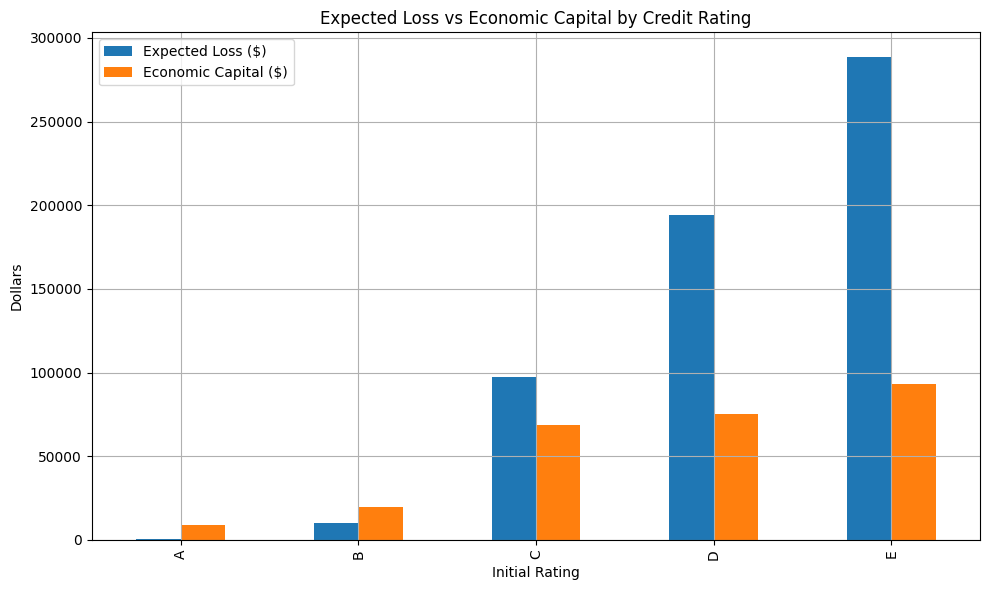

In [5]:
import matplotlib.pyplot as plt

results_df[["Expected Loss ($)", "Economic Capital ($)"]].plot(kind="bar", figsize=(10, 6))
plt.title("Expected Loss vs Economic Capital by Credit Rating")
plt.ylabel("Dollars")
plt.xlabel("Initial Rating")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
Total Capital Requirement = Credit VaR (99%) - Expected Loss


## Monte Carlo Simulation for Credit Portfolio Loss Estimation

This section performs a Monte Carlo simulation to estimate the distribution of credit losses in a portfolio of 1,000 loans, each with a fixed Exposure at Default (EAD) of $1,000,000. The model uses a transition matrix to simulate rating migrations over a one-year horizon and computes losses based on default probabilities and recovery rates associated with the new credit ratings.


### Assumptions

- **Initial portfolio composition**:
  - 30% of credits are rated A
  - 30% are rated B
  - 20% are rated C
  - 15% are rated D
  - 5% are rated E
- **Transition behavior** follows Moody's historical one-year transition matrix
- **Each loan has**:
  - Fixed EAD = $1,000,000
  - Loss is calculated only in case of default after transition
- **Simulations**: 1,000 iterations of the full portfolio


### Methodology

For each simulation:
1. Each loan is assigned an initial rating according to the portfolio composition.
2. Using the transition matrix, a new rating is sampled.
3. The loss is computed as:

   $$
   \text{Loss} = EAD \cdot PD_{\text{new}} \cdot (1 - RR_{\text{new}})
   $$

   where:
   - $PD_{\text{new}}$: probability of default in the new rating
   - $RR_{\text{new}}$: recovery rate in the new rating

4. The total portfolio loss is the sum of individual losses.
5. The process is repeated 10,000 times to build a distribution of portfolio losses.


In [6]:
# Portfolio size
n_loans = 1000
EAD = 1_000_000

# Initial rating distribution (user-defined, can be changed)
initial_dist = {
    "A": 0.30,
    "B": 0.30,
    "C": 0.20,
    "D": 0.15,
    "E": 0.05
}

# Generate initial ratings for each loan
np.random.seed(42)
initial_ratings = np.random.choice(
    ratings,
    size=n_loans,
    p=[initial_dist[r] for r in ratings]
)


In [11]:
n_simulations = 1000
total_losses = []

for sim in range(n_simulations):
    sim_loss = 0

    for i in range(n_loans):
        rating = initial_ratings[i]

        # Simulate transition
        transition_probs = transition_matrix.loc[rating].values
        new_rating = np.random.choice(ratings, p=transition_probs)

        # Get PD and LGD of new rating
        pd_new = recovery_data.loc[new_rating, "PD"]
        lgd_new = 1 - recovery_data.loc[new_rating, "RecoveryRate"]

        # Calculate loss for this loan
        loss = EAD * pd_new * lgd_new
        sim_loss += loss

    total_losses.append(sim_loss)


In [12]:
losses = np.array(total_losses)

expected_portfolio_loss = np.mean(losses)
var_99 = np.percentile(losses, 99)
var_99_9 = np.percentile(losses, 99.9)

print(f"Expected Portfolio Loss: ${expected_portfolio_loss:,.2f}")
print(f"Credit VaR (99%): ${var_99:,.2f}")
print(f"Credit VaR (99.9%): ${var_99_9:,.2f}")


Expected Portfolio Loss: $64,641,940.00
Credit VaR (99%): $66,160,200.00
Credit VaR (99.9%): $66,880,090.00


In [14]:
# --- Previous Results ---
expected_portfolio_loss = 64_641_940.00
var_99 = 66_160_200.00

# --- Approach 1: Economic Capital (VaR - Expected Loss) ---
capital_required_var_minus_el = var_99 - expected_portfolio_loss

# --- Approach 2: Full VaR Capital Buffer ---
capital_required_var_full = var_99

# --- Impresión de resultados ---
print(f"Approach 1 – Economic Capital (VaR - EL): ${capital_required_var_minus_el:,.2f}")
print(f"Approach 2 – Full VaR Capital Buffer:     ${capital_required_var_full:,.2f}")


Approach 1 – Economic Capital (VaR - EL): $1,518,260.00
Approach 2 – Full VaR Capital Buffer:     $66,160,200.00


### Portfolio-Level Simulation Results

Based on 1,000 simulations of the entire portfolio:

- **Expected Portfolio Loss (EL)**:  
  $EL = \$64,641,940.00$

- **Credit Value at Risk (VaR) at 99%**:  
  $VaR_{99\%} = \$66,160,200.00$

- **Credit Value at Risk (VaR) at 99.9%**:  
  $VaR_{99.9\%} = \$66,880,090.00$

### Interpretation

- The simulated **expected loss** aligns with the weighted exposure to lower-rated credits (particularly C, D, E), which drive the majority of risk.
- The **credit VaR at 99%** exceeds the expected loss by approximately $1.5M, representing the capital buffer required under a one-year horizon at a high confidence level.
- The **credit VaR at 99.9%** is only slightly higher, indicating a relatively narrow loss tail. This is consistent with the structure of the transition matrix, where the probability of extremely adverse migrations is low.
- While VaR-based capital is moderate at the portfolio level, it is **significantly higher per-loan** for lower-rated exposures. This is critical when allocating economic capital internally or assessing risk-adjusted returns.

### Total Capital Requirement: Two Approaches

1. **Economic Capital (VaR - Expected Loss):**
   Represents the capital needed to absorb unexpected losses beyond what is statistically expected.

   $$
   \text{Capital} = \text{VaR}_{99\%} - EL = \$66.16M - \$64.64M = \$1.52M
   $$

2. **Conservative Capital (Full 99% VaR):**
   A more conservative approach where the entire VaR is held as buffer, regardless of the expected loss.

   $$
   \text{Capital} = \text{VaR}_{99\%} = \$66.16M
   $$

Both approaches are commonly used. The choice depends on the institution’s risk appetite, regulatory requirements (e.g., CCAR, Basel III), or internal policy.


### Visualization

The histogram below shows the simulated loss distribution with vertical lines indicating:
- **Expected Loss** (green)
- **99% VaR** (orange)
- **99.9% VaR** (red)

This visualization supports internal model validation, capital planning, and regulatory reporting (e.g., ICAAP or CCAR).

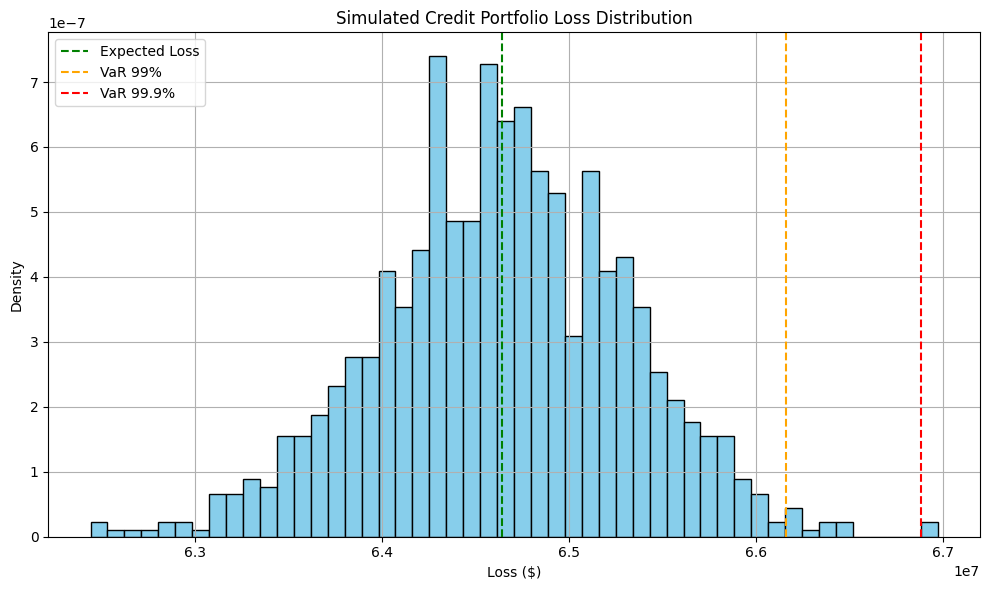

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(losses, bins=50, color='skyblue', edgecolor='black', density=True)
plt.axvline(expected_portfolio_loss, color='green', linestyle='--', label="Expected Loss")
plt.axvline(var_99, color='orange', linestyle='--', label="VaR 99%")
plt.axvline(var_99_9, color='red', linestyle='--', label="VaR 99.9%")
plt.title("Simulated Credit Portfolio Loss Distribution")
plt.xlabel("Loss ($)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
